# [GD-12] Project : End-to-End OCR

## Step 0. 라이브러리 가져오기

In [1]:
# 필요한 라이브러리 가져오기
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image, ImageDraw

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

## **Step 1. Recognition model 구현**

<br>

### 1.1 훈련 데이터 준비

In [2]:
# 경로 지정
path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


#### 1.1.1 데이터셋 안에 들어있는 이미지 확인

- **코드를 실행해 lmdb를 통해 훈련데이터셋의 이미지를 4개만 열어 shape, 이미지나 라벨 확인**

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


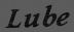

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


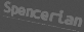

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


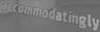

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


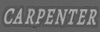

In [3]:
# 데이터셋 안에 들어있는 이미지 확인
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

#### **1.1.2 lmdb를 활용하여 케라스 모델 학습용 `MJSynth`데이터셋 클래스를 구현**

<br>

- **`dataset_path` : 읽어들일 데이터셋의 경로**

- **`label_converter` : 문자를 미리 정의된 index로 변환해주는 converter로 직접 구현**

- **`batch_size`와 입력이미지 크기 그리고 필터링을 위한 최대 글자 수, 학습대상으로 한정하기 위한 character등을 입력으로 받도록 구현**

<br>

- **`_get_img_label()`메소드** 

    - **분석코드처럼 이미지 데이터를 img, label의 쌍으로 가져오는 부분**
    - **다양한 사이즈의 이미지를 모두 height는 32로 맞추고, width는 최대 100까지로 맞추게끔 가공**

- **`__getitem__()` 메소드**

    - **`model.fit()`에서 호출**
    - **배치 단위만큼 `_get_img_label()` 를 통해 가져온 데이터셋을 리턴**

In [4]:
# MJSynth데이터셋 클래스를 구현
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

### **1.2 Encode**

#### 1.2.1 TARGET_CHARACTERS 정의

In [5]:
# TARGET_CHARACTERS 정의
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


#### 1.2.2 **`LabelConverter` 클래스**

- **Label이 우리가 읽을 수 있는 평문 Text로 구성**
- **각 Character를 class로 생각하고 이를 step에 따른 `class index로 변환해서 encode`**
- **`__init__()`**
    - **입력으로 받은 text를 `self.dict`에 각 character들이 어떤 index에 매핑되는지 저장**
    - **character와 index 정보를 통해 모델이 학습할 수 있는 output 생성**
    - **만약 `character='ABCD'`라면 `'A'`의 label은 1, `'B'`의 label은 2,**
    - **공백 문자를 뜻하기 위해 `'-'`를 활용하며, label은 0으로 지정**
- **`decode()`**
    - **각 index를 다시 character로 변환한 후 이어주어 우리가 읽을 수 있는 text로 변형**

In [6]:
# 텍스트를 하나의 문자로 분리, 클래스로 정의(인코드), 디코드 
class LabelConverter(object):
    
    def __init__(self, character):
        self.character = "-" + character
        self.label_map = dict()
        for i, char in enumerate(self.character):
            self.label_map[char] = i
            
    def encode(self, text):
        encoded_label = []
        for i, char in enumerate(text):
            if i > 0 and char == text[i - 1]:
                encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
            encoded_label.append(self.label_map[char])
        return np.array(encoded_label)

    def decode(self, encoded_label):
        target_characters = list(self.character)
        decoded_label = ""
        for encode in encoded_label:
            decoded_label += self.character[encode]
        return decoded_label

In [7]:
# Encode한 후 Decode가 되는지 확인
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 1.3 Build CRNN model

<br>

#### 1.3.1 **Keras에서 제공하는 `K.ctc_batch_cost()`를 활용해서 loss 계산하는 `ctc_lambda_func`를 만들기**

<br>

**텐서플로우 튜토리얼 `K.ctc_batch_cost(y_true, y_pred, input_length, label_length)의` 4가지 인자**

- **`y_true`: tensor (samples, max_string_length) containing the truth labels.**
- **`y_pred`: tensor (samples, time_steps, num_categories) containing the prediction, or output of the softmax.**
- **`input_length tensor`: (samples, 1) containing the sequence length for each batch item in y_pred.**
- **`label_length tensor`: (samples, 1) containing the sequence length for each batch item in y_true.**

- samples는 배치사이즈를 의미

**loss 함수 만들기**

In [8]:
# loss 함수 만들기
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

#### 1.3.2 **`build_crnn_model()`을 구현**

- **`K.ctc_batch_cost()`를 활용**
- **입력  : `image_input`을 으로,**
- **출력 : 마지막 Label 을 'output'이라는 이름으로 출력하는 레이어**

In [9]:
# crnn model 함수 구현
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model

### 1.4 Train 

#### 1.4.1 MJDatasetSequence로 데이터를 분리하여 구성된 데이터셋 & 모델 생성

In [10]:
# MJDatasetSequence로 데이터를 분리하여 구성된 데이터셋
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

# 모델 생성
model = build_crnn_model()

#### 1.4.2 model compile

In [11]:
# 모델을 컴파일
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, clipnorm=3.)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

#### 1.4.3 모델훈련

- **EarlyStopping을 이용**

In [12]:
# 모델 훈련
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_RMSprop.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=100,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/100
565/565 [==============================] - 109s 162ms/step - loss: 24.8018 - val_loss: 21.8058

Epoch 00001: val_loss improved from inf to 21.80579, saving model to /aiffel/aiffel/ocr/model_RMSprop.hdf5
Epoch 2/100
565/565 [==============================] - 86s 152ms/step - loss: 9.9607 - val_loss: 5.9458

Epoch 00002: val_loss improved from 21.80579 to 5.94575, saving model to /aiffel/aiffel/ocr/model_RMSprop.hdf5
Epoch 3/100
565/565 [==============================] - 86s 151ms/step - loss: 4.2285 - val_loss: 4.0159

Epoch 00003: val_loss improved from 5.94575 to 4.01590, saving model to /aiffel/aiffel/ocr/model_RMSprop.hdf5
Epoch 4/100
565/565 [==============================] - 85s 151ms/step - loss: 3.0150 - val_loss: 3.1665

Epoch 00004: val_loss improved from 4.01590 to 3.16645, saving model to /aiffel/aiffel/ocr/model_RMSprop.hdf5
Epoch 5/100
565/565 [==============================] - 85s 151ms/step - loss: 2.3958 - val_loss: 2.9374

Epoch 00005: val_loss improved fro

### 1.5 모델 평가


#### 1.5.1 학습된 모델 불러오기 & inference 모델 생성

In [13]:
# 학습된 모델을 테스트셋을 통해 확인
# 다음은 학습된 모델의 가중치가 저장된 경로
checkpoint_path = HOME_DIR + '/model_RMSprop.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

#### 1.5.2 모델 성능 확인

Result: 	 SLINKING


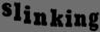

Result: 	 ALEPPO


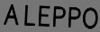

Result: 	 RWANDA


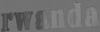

Result: 	 NATHANS


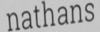

Result: 	 HALLO


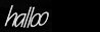

Result: 	 HURLS


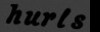

Result: 	 DOWNSIZE


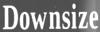

Result: 	 ROBOTIC


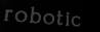

Result: 	 SLAPPY


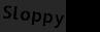

Result: 	 HERMITE


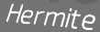

In [14]:
# 학습된 모델의 성능 확인
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        if index != -1:
            text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

## Step 2. 샘플 이미지 OCR

### 2.1 이미지의 문자 찾기

In [21]:
# detector 정의, 이미지 경로 지정
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'
SAMPLE_IMG_PATH1 = HOME_DIR + '/manitoba.jpeg'
detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [16]:
def detect_text(img_path):
    
    # 이미지 불러오기
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
        # 배치 크기를 위해서 dimension을 확장해주고 kera-ocr의 입력 차원에 맞게 H,W,C로 변경합니다.
    det_result = detector.detect(img.numpy())
        # 배치의 첫 번째 결과만 가져옵니다.
    ocr_result = det_result[0]

        
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

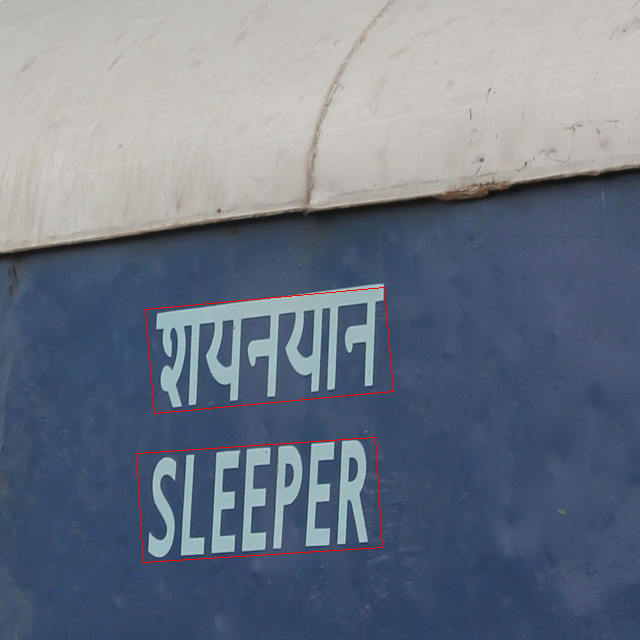

In [17]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

(-0.5, 254.5, 134.5, -0.5)

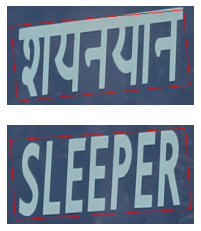

In [18]:
import matplotlib.pyplot as plt
plt.subplot(2, 1, 1)
plt.imshow(cropped_img[0])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cropped_img[1])
plt.axis('off')

In [19]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 IUIL


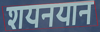

Result: 	 SLEEPER


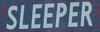

In [20]:
for _img in cropped_img:
    recognize_img(_img)

- 결과값이 마음에 들지는 않는다. 정확히 detection되지 않는 것 같다.
- learning late를 바꿔서 해 봤는 데, overfitting 되어서 인지 val_lpss가 early_stopping을 하니 생각보다 빨리 정지 된다.
- val_loss가 안정되지 않는다. 어떤 것을 변경해서 조정해야 하는 지도 알 수 있다면 좋을 탠데..
- optimizer를 RMSprop로 변경해서 loss를 내리고 이미지를 확인해보니 기본것보다 출력이 좋아서 이것으로 채택..
- 다른 이미지로도 해 봤는 데, 엉망이었다.. 더 정교한 것이 필요할 것 같다.
- earlystopping을 없애고 100 epoch를 해 봤지만, earlystopping을 주고 한 것이랑 비슷했다.

## Step 3. optimizer 노드에 있는 것 그대로

In [11]:
# 모델을 컴파일
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

In [12]:
# 모델 훈련
# 훈련이 빨리 끝날 수 있도록 ModelCheckPoint와 EarlyStopping을 사용합니다
checkpoint_path = HOME_DIR + '/model_basic.hdf5'
ckp = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_loss',
    verbose=1, save_best_only=True, save_weights_only=True
)
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'
)
model.fit(train_set,
          steps_per_epoch=len(train_set),
          epochs=100,
          validation_data=val_set,
          validation_steps=len(val_set),
          callbacks=[ckp, earlystop])

Epoch 1/100
565/565 [==============================] - 100s 155ms/step - loss: 25.6909 - val_loss: 24.9704

Epoch 00001: val_loss improved from inf to 24.97040, saving model to /aiffel/aiffel/ocr/model_basic.hdf5
Epoch 2/100
565/565 [==============================] - 86s 153ms/step - loss: 15.9478 - val_loss: 10.6466

Epoch 00002: val_loss improved from 24.97040 to 10.64658, saving model to /aiffel/aiffel/ocr/model_basic.hdf5
Epoch 3/100
565/565 [==============================] - 85s 150ms/step - loss: 7.5424 - val_loss: 7.2505

Epoch 00003: val_loss improved from 10.64658 to 7.25051, saving model to /aiffel/aiffel/ocr/model_basic.hdf5
Epoch 4/100
565/565 [==============================] - 85s 151ms/step - loss: 5.3809 - val_loss: 5.5875

Epoch 00004: val_loss improved from 7.25051 to 5.58749, saving model to /aiffel/aiffel/ocr/model_basic.hdf5
Epoch 5/100
565/565 [==============================] - 84s 149ms/step - loss: 4.2545 - val_loss: 4.7690

Epoch 00005: val_loss improved from 5.

In [31]:
# 학습된 모델을 테스트셋을 통해 확인
# 다음은 학습된 모델의 가중치가 저장된 경로
checkpoint_path = HOME_DIR + '/model_basic.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


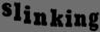

Result: 	 ALEPPO


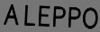

Result: 	 ITWNDA


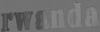

Result: 	 NATHANS


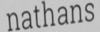

Result: 	 HALB


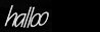

Result: 	 HURLS


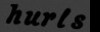

Result: 	 DOWNSIZE


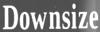

Result: 	 ROBOTIC


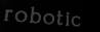

Result: 	 SLOPPY


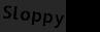

Result: 	 HERMITE


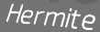

In [32]:
# 학습된 모델의 성능 확인
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        if index != -1:
            text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [33]:
# detector 정의, 이미지 경로 지정
from keras_ocr.detection import Detector

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [34]:
def detect_text(img_path):
    
    # 이미지 불러오기
    img_pil = Image.open(img_path)
    img_pil = img_pil.resize((640, 640))
    img_draw=ImageDraw.Draw(img_pil)
    result_img = img_pil
    
    img = Image.open(img_path)
    img = tf.image.resize(img, (640, 640))
    img = img[tf.newaxis, :, :, :]
    det_result = detector.detect(img.numpy())
    ocr_result = det_result[0]

        
    cropped_imgs = []
    for text_result in ocr_result:
        img_draw.polygon(text_result, outline='red')
        x_min = text_result[:,0].min() - 5
        x_max = text_result[:,0].max() + 5
        y_min = text_result[:,1].min() - 5
        y_max = text_result[:,1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))


    return result_img, cropped_imgs

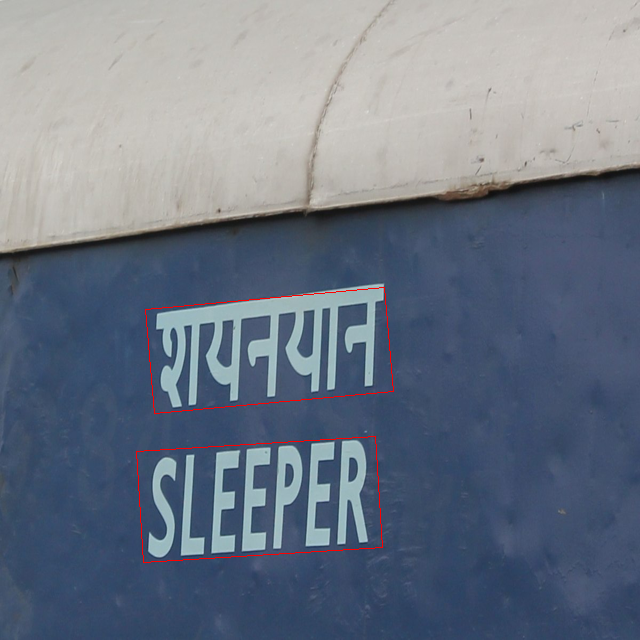

In [35]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

(-0.5, 254.5, 136.5, -0.5)

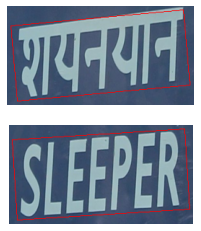

In [36]:
plt.subplot(2, 1, 1)
plt.imshow(cropped_img[0])
plt.axis('off')

plt.subplot(2, 1, 2)
plt.imshow(cropped_img[1])
plt.axis('off')

In [37]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!
    pil_img = pil_img.resize(input_img_size)
    np_img = np.array(pil_img)
    np_img = np.transpose(np_img, (1, 0, 2))
    np_img = np_img[np.newaxis, :, :, :]
    output = model_pred.predict(np_img)
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img).astype(np.uint8)))

Result: 	 FTRYFT


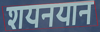

Result: 	 SLEEPER


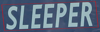

In [38]:
for _img in cropped_img:
    recognize_img(_img)

## 회고
- 이번 프로젝트에서 **어려웠던 점**
    - 노드를 열심히 읽고 또 읽었는 데, 너무 많은 것들을 공부해서 인지 머릿속이 어지럽다.
    - 노드의 말은 이해가 되는 데 코드 해석이 어려웠다.
- 프로젝트를 진행하면서 **알아낸 점**
    - OCR과정을 조금 알게 되었다.
- 프로젝트를 진행하면서 **아직 모호한 점**
    - 코드를 이해하는 것이 아직 어렵다.
    - 이미지를 읽어오는 방법이 여러가지인데 언제 적재적소에 쓰는 것인지 모르겠다.
- 정리되지 않은 파일처럼 머리속이 뒤죽박죽이다. 이 머리속의 것들을 어떻게 정리해야 할 지 모르겠다.